Loaded 32071 simulations
Using sample 16041 → /mnt/data/darus/h5/16041.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 7.0e-02 9.5e-01 1.0e+05]

--- Springback stats ---
Ground_Truth    : mean=0.2186,  max=0.6825,  std=0.1782
Prediction  : mean=0.2102, max=0.5471, std=0.1652
Difference : mean=0.0450,  max=0.2546,  std=0.0321


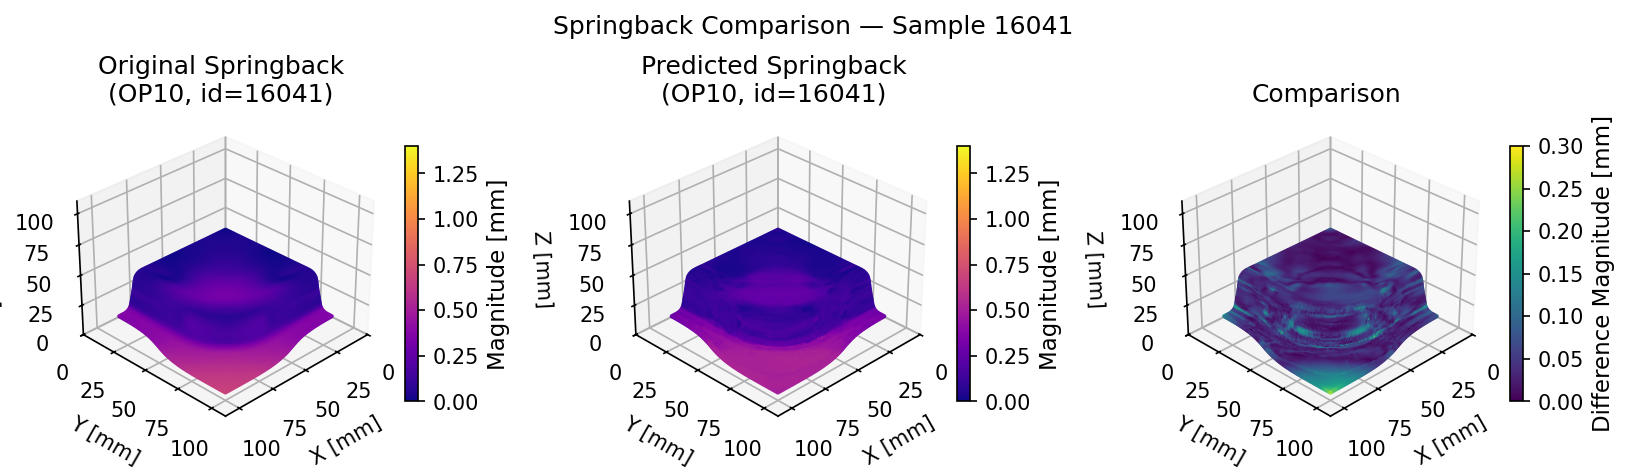

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import ticker
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback

# Config
OPERATION   = 10                    
TIMESTEP    = 2                    
sample_id   = "16041"              
# pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/grit_like"
pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like"
data_root   = "/mnt/data/jiang"     
data_dir    = Path("/mnt/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

# Load dataset + files
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh 
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback 
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)  

# Compute magnitudes 
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm] np.linalg.norm(..., axis=1) takes the Euclidean (L2) norm row-wise
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector  = disp_pred - disp_gt
difference_mag  = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth    : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction  : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

# All panels plotted at the same coordinates (GT final coords) for easy comparison.
# If undeformed mesh: use coords_plot = node_coords
# If predicted final pose: use coords_plot = node_coords + disp_pred
coords_plot = node_coords + disp_gt  

# plotting with existing routine
global_springback_min = 0.0
global_springback_max = 1.4
norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
global_springback_min_difference = 0.0
global_springback_max_difference = 0.3
norm_difference = Normalize(vmin=global_springback_min_difference, vmax=global_springback_max_difference) 


fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Create color
col1  = plt.cm.plasma(norm(mag_gt))
col2  = plt.cm.plasma(norm(mag_pred))
col3  = plt.cm.viridis(norm_difference(difference_mag))

# threshold = 0.1  # mm
# bright_color = np.array([1,0,0,1])  

# col1[mag_gt < threshold] = bright_color
# col2[mag_pred < threshold] = bright_color
# col3[difference_mag > threshold] = bright_color

# # colorbar-specific colormaps & norms so the bar shows the bright under-range
# cmap_plasma_cb  = plt.cm.get_cmap("plasma").copy()
# cmap_viridis_cb = plt.cm.get_cmap("viridis").copy()
# cmap_plasma_cb.set_under(bright_color)
# cmap_viridis_cb.set_under(bright_color)

# norm_cb        = Normalize(vmin=threshold, vmax=global_springback_max)
#norm_diff_cb   = Normalize(vmin=threshold, vmax=global_springback_max_difference)
# norm_diff_cb   = Normalize(vmin=0, vmax=threshold)

# Figure 1: Original magnitude 
ax1 = fig.add_subplot(131, projection="3d")
p1 = ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm), "Magnitude [mm]")
# add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap=cmap_plasma_cb, norm=norm_cb), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# Figure 2: Pred magnitude 
ax2 = fig.add_subplot(132, projection="3d")

p2 = ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm), "Magnitude [mm]")
# add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap=cmap_plasma_cb, norm=norm_cb), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# Figure 3: Difference magnitude ||pred - gt|| 
ax3 = fig.add_subplot(133, projection="3d")
p3 = ax3.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col3, s=1, alpha=0.95)
add_colorbar(fig, ax3, plt.cm.ScalarMappable(cmap="viridis", norm=norm_difference), "Difference Magnitude [mm]")
# add_colorbar(fig, ax3, plt.cm.ScalarMappable(cmap=cmap_viridis_cb, norm=norm_diff_cb), "Difference Magnitude [mm]")
ax3.set_title("Comparison")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

plt.suptitle(f"Springback Comparison — Sample {sim_id}", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")

save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
if pred_dir == "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like":
    fig.savefig(save_dir / f"springback_id{sample_id}_graphormer_like_with_lap_loss.png",
                dpi=150,                 # pixel density (inches × dpi = pixels)
                bbox_inches="tight",     # trim extra margins
                pad_inches=0.1) 
else:
    fig.savefig(save_dir / f"springback_id{sample_id}_grit_like_without_lap_loss.png",
                dpi=150,                 # pixel density (inches × dpi = pixels)
                bbox_inches="tight",     # trim extra margins
                pad_inches=0.1) 
plt.show()



In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm  # <-- added LogNorm
from matplotlib import ticker
from matplotlib.ticker import LogFormatter, LogLocator  # for log colorbar ticks
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback

# Config
OPERATION   = 10
TIMESTEP    = 2
sample_id   = "16041"
# pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/grit_like"
pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like"
data_root   = "/mnt/data/jiang"
data_dir    = Path("/mnt/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    # Auto formatting based on norm type
    if isinstance(mappable.norm, LogNorm):
        cbar.locator = LogLocator(base=10)
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

# Load dataset + files
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)

# Compute magnitudes
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm]
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector = disp_pred - disp_gt
difference_mag    = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction   : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference   : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

# Coordinates to plot (use GT final pose for all panels for easy comparison)
coords_plot = node_coords + disp_gt

# Color normalization
global_springback_min = 0.0
global_springback_max = 1.4
norm_linear = Normalize(vmin=global_springback_min, vmax=global_springback_max)

# For the difference panel (log scale): vmin must be > 0
global_springback_min_difference = 0.0
global_springback_max_difference = 0.3

eps = 1e-9
pos = difference_mag[difference_mag > 0]
vmin_log = float(pos.min()) if pos.size else eps
vmin_log = max(vmin_log, eps)
vmax_log = max(global_springback_max_difference, vmin_log * 1.1)
norm_difference = LogNorm(vmin=vmin_log, vmax=vmax_log)
difference_mag_safe = np.clip(difference_mag, vmin_log, None)

print(f"\n[LogNorm] vmin={vmin_log:.3e}, vmax={vmax_log:.3e}")

# Figure
fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Precompute colors for the linear panels (GT & Pred)
col1 = plt.cm.plasma(norm_linear(mag_gt))
col2 = plt.cm.plasma(norm_linear(mag_pred))

# --- Panel 1: Original magnitude (linear) ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# --- Panel 2: Predicted magnitude (linear) ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# --- Panel 3: Difference ||pred - gt|| (LOG scale) ---
ax3 = fig.add_subplot(133, projection="3d")
sc3 = ax3.scatter(
    coords_plot[:,0], coords_plot[:,1], coords_plot[:,2],
    c=difference_mag_safe, cmap="viridis", norm=norm_difference,
    s=1, alpha=0.95
)
add_colorbar(fig, ax3, plt.cm.ScalarMappable(cmap="viridis", norm=norm_difference), "Difference Magnitude [mm]")
ax3.set_title("Comparison (Log Scale)")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

plt.suptitle(f"Springback Comparison — Sample {sim_id}", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")
save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
if pred_dir == "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like":
    fig.savefig(save_dir / f"springback_id{sample_id}_graphormer_like_with_lap_loss.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)
else:
    fig.savefig(save_dir / f"springback_id{sample_id}_grit_like_with_lap_loss_logscale.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)

plt.show()


Loaded 32071 simulations
Using sample 16041 → /mnt/data/darus/h5/16041.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 7.0e-02 9.5e-01 1.0e+05]


FileNotFoundError: [Errno 2] No such file or directory: '/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like/16041_pred_node_displacement.npy'